In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [2]:
gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    device = 'cuda:' + str(gpu_ids[0])  # 여기서 gpu 번호 고르기
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

[0]
['NVIDIA GeForce RTX 3080']
cuda


In [3]:
points, labels = make_moons(n_samples=2000, shuffle=False ,noise=0.1)

In [4]:
points_l = np.array((points[10], points[500], points[900], points[1300], points[1500], points[1800]))
labels_l = np.array((labels[10], labels[500], labels[900], labels[1300], labels[1500], labels[1800]))

In [5]:
# print(points[0], labels[0], points[500], labels[500], points[999], labels[999])
# print(points[1300], labels[1300], points[1500], labels[1500], points[1800], labels[1800])

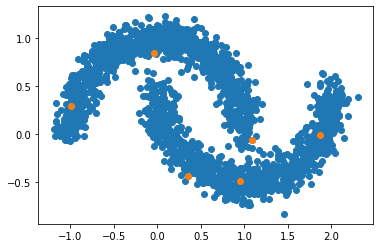

In [6]:
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])

In [7]:
class TMClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.Sigmoid(),
            nn.Linear(in_features=8, out_features=8),
            nn.Sigmoid(),
            nn.Linear(in_features=8, out_features=2),
            nn.Sigmoid()
        )

        self.init_weight()

    def init_weight(self):
        for layer in self.layers:
            if(isinstance(layer, nn.Linear)):
                nn.init.uniform_(layer.weight, -0.1, 0.1)

    def forward(self, x):
        return self.layers(x)

In [8]:
supervised = TMClassifier().to(device=device)
pseudoLabel = TMClassifier().to(device=device)
metaPseudoLabel = TMClassifier().to(device=device)
lr = 0.1
opt_s = torch.optim.SGD(supervised.parameters(), lr=lr)
opt_pl = torch.optim.SGD(pseudoLabel.parameters(), lr=lr)
opt_mpl = torch.optim.SGD(metaPseudoLabel.parameters(), lr=lr)

In [9]:
creterion = nn.CrossEntropyLoss()

In [10]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.len = len(y_data)
    
    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]
        
        if self.transform:
            sample = self.transform(sample)   #self.transform이 None이 아니라면 전처리
        return sample 
    
    def __len__(self):
        return self.len

In [11]:
labeledData = MyDataset(points_l, labels_l)
unlabeledData = MyDataset(points, labels)

labeledLoader = DataLoader(labeledData, batch_size=6, shuffle=True)
unlabeledLoader = DataLoader(unlabeledData, batch_size=1024, shuffle=True)

In [12]:
epoch = 0
max_epoch = 3e4 + 1

In [13]:
while(epoch < max_epoch):
    for point, label in labeledLoader:
        opt_s.zero_grad()

        output = supervised(point.float().to(device))

        loss = creterion(output.cpu(), label)

        loss.backward()
        opt_s.step()

    if(epoch%1e3 == 0):
        _, preds = torch.max(output, 1)
        acc = torch.sum(preds.cpu() == label)

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tAcc: {acc.item()}')
    
    epoch += 1

Epoch: 0 	Loss: 0.6941 	Acc: 3
Epoch: 1000 	Loss: 0.6931 	Acc: 3
Epoch: 2000 	Loss: 0.6931 	Acc: 3
Epoch: 3000 	Loss: 0.6930 	Acc: 3
Epoch: 4000 	Loss: 0.6929 	Acc: 3
Epoch: 5000 	Loss: 0.6927 	Acc: 4
Epoch: 6000 	Loss: 0.6921 	Acc: 5
Epoch: 7000 	Loss: 0.6896 	Acc: 5
Epoch: 8000 	Loss: 0.6683 	Acc: 5
Epoch: 9000 	Loss: 0.5362 	Acc: 5
Epoch: 10000 	Loss: 0.4895 	Acc: 5
Epoch: 11000 	Loss: 0.4433 	Acc: 5
Epoch: 12000 	Loss: 0.4011 	Acc: 6
Epoch: 13000 	Loss: 0.3672 	Acc: 6
Epoch: 14000 	Loss: 0.3463 	Acc: 6
Epoch: 15000 	Loss: 0.3348 	Acc: 6
Epoch: 16000 	Loss: 0.3283 	Acc: 6
Epoch: 17000 	Loss: 0.3244 	Acc: 6
Epoch: 18000 	Loss: 0.3219 	Acc: 6
Epoch: 19000 	Loss: 0.3203 	Acc: 6
Epoch: 20000 	Loss: 0.3191 	Acc: 6
Epoch: 21000 	Loss: 0.3182 	Acc: 6
Epoch: 22000 	Loss: 0.3175 	Acc: 6
Epoch: 23000 	Loss: 0.3170 	Acc: 6
Epoch: 24000 	Loss: 0.3166 	Acc: 6
Epoch: 25000 	Loss: 0.3162 	Acc: 6
Epoch: 26000 	Loss: 0.3159 	Acc: 6
Epoch: 27000 	Loss: 0.3157 	Acc: 6
Epoch: 28000 	Loss: 0.3155 	Acc: 

In [14]:
epoch = 0

while(epoch < max_epoch):
    for point, label in unlabeledLoader:
        opt_pl.zero_grad()

        pseudo_label = supervised(point.float().to(device))
        output = pseudoLabel(point.float().to(device))

        loss = creterion(output, pseudo_label)

        loss.backward()
        opt_pl.step()

    if(epoch%1e3 == 0):
        _, preds = torch.max(output, 1)
        acc = torch.sum(preds == label.to(device))

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tAcc: {acc.item()} / {point.shape[0]}')
    
    epoch += 1

Epoch: 0 	Loss: 0.7120 	Acc: 508 / 976
Epoch: 1000 	Loss: 0.5836 	Acc: 499 / 976
Epoch: 2000 	Loss: 0.5862 	Acc: 481 / 976
Epoch: 3000 	Loss: 0.6027 	Acc: 495 / 976
Epoch: 4000 	Loss: 0.5931 	Acc: 486 / 976
Epoch: 5000 	Loss: 0.5915 	Acc: 489 / 976
Epoch: 6000 	Loss: 0.5776 	Acc: 482 / 976
Epoch: 7000 	Loss: 0.4785 	Acc: 684 / 976
Epoch: 8000 	Loss: 0.3812 	Acc: 774 / 976
Epoch: 9000 	Loss: 0.3533 	Acc: 767 / 976
Epoch: 10000 	Loss: 0.3425 	Acc: 752 / 976
Epoch: 11000 	Loss: 0.3361 	Acc: 757 / 976
Epoch: 12000 	Loss: 0.3323 	Acc: 753 / 976
Epoch: 13000 	Loss: 0.3312 	Acc: 757 / 976
Epoch: 14000 	Loss: 0.3279 	Acc: 757 / 976
Epoch: 15000 	Loss: 0.3260 	Acc: 761 / 976
Epoch: 16000 	Loss: 0.3257 	Acc: 754 / 976
Epoch: 17000 	Loss: 0.3273 	Acc: 763 / 976
Epoch: 18000 	Loss: 0.3296 	Acc: 759 / 976
Epoch: 19000 	Loss: 0.3248 	Acc: 753 / 976
Epoch: 20000 	Loss: 0.3255 	Acc: 764 / 976
Epoch: 21000 	Loss: 0.3238 	Acc: 760 / 976
Epoch: 22000 	Loss: 0.3266 	Acc: 740 / 976
Epoch: 23000 	Loss: 0.32

In [15]:
x = np.linspace(-1.5, 2.5, num=1000)
y = np.linspace(-1.5, 1.5, num=1000)

X,Y = np.meshgrid(x,y)

# plt.scatter(X, Y)

In [16]:
arr = np.stack((X.flatten(),Y.flatten()),axis=1)

In [17]:
renderData = MyDataset(arr, np.zeros_like(arr))

renderLoader = DataLoader(renderData, batch_size=1024, shuffle=False, drop_last=False)

In [18]:
s_preds = np.array([])
pl_preds = np.array([])

for point, _ in renderLoader:
    # print(point)
    _, s_pred = torch.max(supervised(point.float().to(device)), 1)
    _, pl_pred = torch.max(pseudoLabel(point.float().to(device)), 1)
    # break

    s_preds = np.concatenate((s_preds,s_pred.cpu().numpy()))
    pl_preds = np.concatenate((pl_preds,pl_pred.cpu().numpy()))

In [19]:
print(arr.shape, s_preds.shape, pl_preds.shape)

(1000000, 2) (1000000,) (1000000,)


In [20]:
s_pred_points_0 = []
s_pred_points_1 = []
pl_pred_points_0 = []
pl_pred_points_1 = []

for i in range(arr.shape[0]):
    if(s_preds[i] == 0):
        s_pred_points_0.append(arr[i])
    else:
        s_pred_points_1.append(arr[i])
    if(pl_preds[i] == 0):
        pl_pred_points_0.append(arr[i])
    else:
        pl_pred_points_1.append(arr[i])

print(len(s_pred_points_0),len(s_pred_points_1))
print(len(pl_pred_points_0),len(pl_pred_points_1))

601044 398956
601340 398660


In [21]:
np.array(s_pred_points_0).shape

(601044, 2)

[None, None]

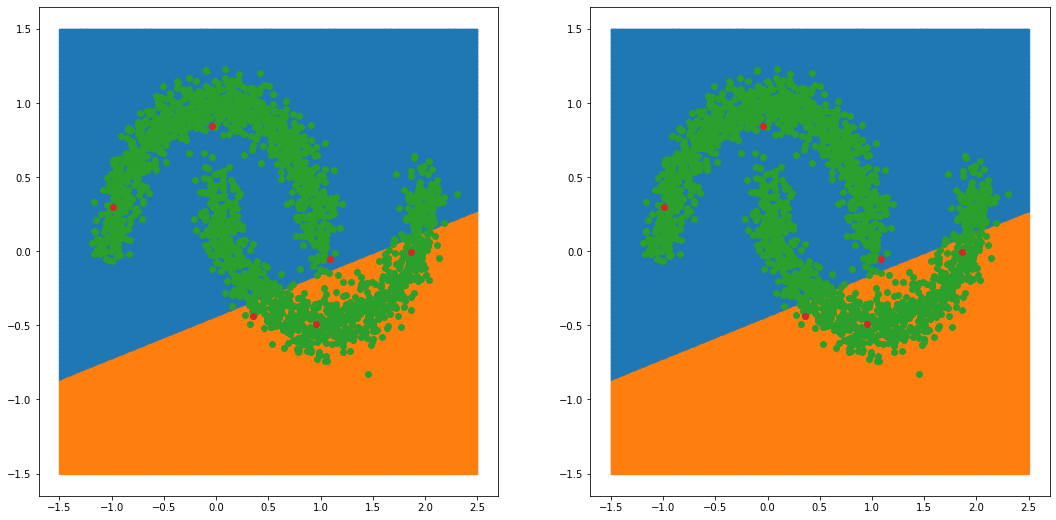

In [22]:
gridshape = (1, 3)
marker_size = 0.1

loc = (0,0)
ax = plt.subplot2grid(gridshape, loc)

plt.scatter(np.array(s_pred_points_0)[:,0], np.array(s_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(s_pred_points_1)[:,0], np.array(s_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])

loc = (0,1)
ax = plt.subplot2grid(gridshape, loc)

plt.scatter(np.array(pl_pred_points_0)[:,0], np.array(pl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(pl_pred_points_1)[:,0], np.array(pl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])

ax.figure.set(figwidth=28, figheight=9)

In [23]:
epoch = 0

while(epoch < max_epoch):
    for point, label in unlabeledLoader:
        # concatenate unlabeled data and labeled data for efficiency
        batch_size = point.shape[0]
        points_ = torch.concat((point.to(device), torch.tensor(points_l, device=device))).float()
        labels = torch.tensor(labels_l, device=device)
        
        opt_mpl.zero_grad()
        opt_s.zero_grad()
        
        # sample pseudo label using teacher model(supervised) on unlabeled data
        output_t = supervised(points_)
        pseudo_label = output_t[:batch_size]

        # get loss of student on unlabeled input using pseudo label
        output = metaPseudoLabel(points_)
        loss = creterion(output[:batch_size], pseudo_label)

        # store old loss of student on labeled data
        loss_old = nn.functional.cross_entropy(output[batch_size:].detach(), labels)

        # update student
        loss.backward(retain_graph=True)
        opt_mpl.step()
        
        with torch.no_grad():
            out_new = metaPseudoLabel(points_[batch_size:])
            loss_new = nn.functional.cross_entropy(out_new.detach(), labels)

        # compute dot product(h) using first order Taylor series
        # f(a+h) - f(a) = f'(a)h
        # h = loss_old - loss_new # theoretically
        h = loss_new - loss_old # official code

        # compute teacher loss
        _, hard_pseudo_label = torch.max(pseudo_label.detach(), dim=-1)
        loss_t_mpl = h * nn.functional.cross_entropy(pseudo_label, hard_pseudo_label)
        loss_t_supervised = nn.functional.cross_entropy(output_t[batch_size:], labels)

        loss_t = loss_t_mpl + loss_t_supervised
        loss_t.backward()
        opt_s.step()


    if(epoch%1e3 == 0):
        _, preds = torch.max(output[:batch_size], dim=-1)
        acc = torch.sum(preds == label.to(device))

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tAcc: {acc.item()} / {point.shape[0]}')
    
    epoch += 1

Epoch: 0 	Loss: 0.7042 	Acc: 479 / 976
Epoch: 1000 	Loss: 0.5597 	Acc: 499 / 976
Epoch: 2000 	Loss: 0.5680 	Acc: 480 / 976
Epoch: 3000 	Loss: 0.5641 	Acc: 486 / 976
Epoch: 4000 	Loss: 0.5396 	Acc: 498 / 976
Epoch: 5000 	Loss: 0.5483 	Acc: 517 / 976
Epoch: 6000 	Loss: 0.5631 	Acc: 484 / 976
Epoch: 7000 	Loss: 0.5575 	Acc: 484 / 976
Epoch: 8000 	Loss: 0.5575 	Acc: 492 / 976
Epoch: 9000 	Loss: 0.5785 	Acc: 472 / 976
Epoch: 10000 	Loss: 0.5303 	Acc: 487 / 976
Epoch: 11000 	Loss: 0.5516 	Acc: 481 / 976
Epoch: 12000 	Loss: 0.0941 	Acc: 471 / 976
Epoch: 13000 	Loss: 0.0884 	Acc: 489 / 976
Epoch: 14000 	Loss: 0.0811 	Acc: 473 / 976
Epoch: 15000 	Loss: 0.0799 	Acc: 489 / 976
Epoch: 16000 	Loss: 0.0784 	Acc: 482 / 976
Epoch: 17000 	Loss: 0.0785 	Acc: 494 / 976
Epoch: 18000 	Loss: 0.0798 	Acc: 482 / 976
Epoch: 19000 	Loss: 0.0792 	Acc: 494 / 976
Epoch: 20000 	Loss: 0.0810 	Acc: 495 / 976
Epoch: 21000 	Loss: 0.0818 	Acc: 492 / 976
Epoch: 22000 	Loss: 0.0786 	Acc: 487 / 976
Epoch: 23000 	Loss: 0.07

In [27]:
s_preds = np.array([])
mpl_preds = np.array([])

for point, _ in renderLoader:
    _, s_pred = torch.max(supervised(point.float().to(device)), 1)
    _, mpl_pred = torch.max(metaPseudoLabel(point.float().to(device)), dim=-1)

    s_preds = np.concatenate((s_preds,s_pred.cpu().numpy()))
    mpl_preds = np.concatenate((mpl_preds,mpl_pred.cpu().numpy()))

In [28]:
s_pred_points_0 = []
s_pred_points_1 = []
mpl_pred_points_0 = []
mpl_pred_points_1 = []

for i in range(arr.shape[0]):
    if(s_preds[i] == 0):
        s_pred_points_0.append(arr[i])
    else:
        s_pred_points_1.append(arr[i])
    if(mpl_preds[i] == 0):
        mpl_pred_points_0.append(arr[i])
    else:
        mpl_pred_points_1.append(arr[i])

print(len(s_pred_points_0),len(s_pred_points_1))
print(len(mpl_pred_points_0),len(mpl_pred_points_1))

598701 401299
0 1000000


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

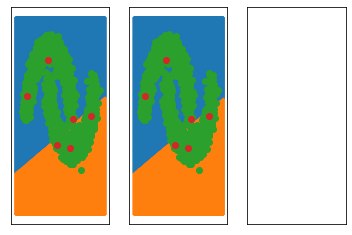

In [29]:
gridshape = (1, 3)
marker_size = 0.1

loc = (0,0)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(s_pred_points_0)[:,0], np.array(s_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(s_pred_points_1)[:,0], np.array(s_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])

loc = (0,1)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(pl_pred_points_0)[:,0], np.array(pl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(pl_pred_points_1)[:,0], np.array(pl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])

loc = (0,2)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(mpl_pred_points_0)[:,0], np.array(mpl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(mpl_pred_points_1)[:,0], np.array(mpl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])

ax.figure.set(figwidth=32, figheight=9)